# Portfolio Code 

In [25]:
# Libraries 

import json
import os
import pathlib

import earthpy
import hvplot.xarray
import rioxarray as rxr
import xarray as xr

import geopandas as gpd
import hvplot.pandas
import holoviews as hv


from glob import glob
import pandas as pd
from shapely.geometry import mapping
import matplotlib.pyplot as plt



<Axes: >

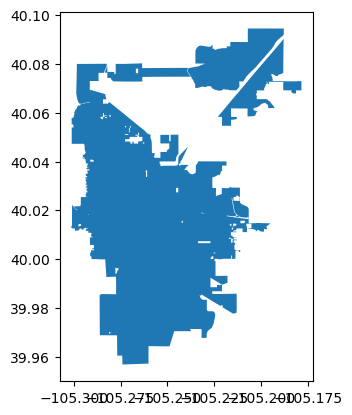

In [22]:
boulder_gdf = ox.geocode_to_gdf(
    'Boulder, Colorado, United States')

boulder_gdf

boulder_gdf.plot()

In [12]:
# NDVI 
project = earthpy.Project(dirname='newboulder_county_ndvi')

# Get a sorted list of NDVI tif file paths
ndvi_paths = sorted(list(project.project_dir.rglob('MOD13Q1.061__250m_16_days_NDVI*.tif')))

# Display the first and last three files paths to check the pattern
ndvi_paths[:3], ndvi_paths[-3:]

([PosixPath('/workspaces/data/newboulder_county_ndvi/boulder_county_ndvi/MOD13Q1.061__250m_16_days_NDVI_doy2002113000000_aid0001.tif'),
  PosixPath('/workspaces/data/newboulder_county_ndvi/boulder_county_ndvi/MOD13Q1.061__250m_16_days_NDVI_doy2002129000000_aid0001.tif'),
  PosixPath('/workspaces/data/newboulder_county_ndvi/boulder_county_ndvi/MOD13Q1.061__250m_16_days_NDVI_doy2002145000000_aid0001.tif')],
 [PosixPath('/workspaces/data/newboulder_county_ndvi/boulder_county_ndvi/MOD13Q1.061__250m_16_days_NDVI_doy2022177000000_aid0001.tif'),
  PosixPath('/workspaces/data/newboulder_county_ndvi/boulder_county_ndvi/MOD13Q1.061__250m_16_days_NDVI_doy2022193000000_aid0001.tif'),
  PosixPath('/workspaces/data/newboulder_county_ndvi/boulder_county_ndvi/MOD13Q1.061__250m_16_days_NDVI_doy2022209000000_aid0001.tif')])

In [13]:

ndvi_das = []

for ndvi_path in ndvi_paths:
    # Get date from file name
    fname = ndvi_path.name  # just the filename, not the whole path
    # find the substring "doy" and take the next 7 digits (YYYYDDD)
    doy_index = fname.find("doy") + 3
    date_str = fname[doy_index:doy_index + 7]  # e.g. '2001145'
    year = int(date_str[:4])
    doy = int(date_str[4:])
    date = pd.to_datetime(f"{year}-{doy}", format="%Y-%j")
    
    # Open dataset
    da = rxr.open_rasterio(ndvi_path, masked=True).squeeze()
    
    # Add date dimension and clean up metadata 
    da = da.assign_coords({'date': date}).expand_dims({'date': [date]})
    da.name = 'NDVI'
    
    # Prepare for concatenation
    ndvi_das.append(da)

ndvi_da = xr.combine_by_coords(ndvi_das, coords=['date'])


/tmp/ipykernel_28774/3145327063.py:23: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ndvi_da = xr.combine_by_coords(ndvi_das, coords=['date'])
/tmp/ipykernel_28774/3145327063.py:23: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ndvi_da = xr.combine_by_coords(ndvi_das, coords=['date'])


In [14]:
ndvi_da

<xarray.Dataset> Size: 31MB
Dimensions:      (date: 147, y: 169, x: 309)
Coordinates:
  * date         (date) datetime64[ns] 1kB 2002-04-23 2002-05-09 ... 2022-07-28
    band         int64 8B 1
  * x            (x) float64 2kB -105.7 -105.7 -105.7 ... -105.1 -105.1 -105.1
  * y            (y) float64 1kB 40.26 40.26 40.26 40.26 ... 39.92 39.92 39.91
    spatial_ref  int64 8B 0
Data variables:
    NDVI         (date, y, x) float32 31MB 278.0 278.0 ... 3.29e+03 3.29e+03

In [15]:
# 2001–2010
ndvi_2001_2010 = ndvi_da.sel(date=slice('2002', '2010'))

# temporal mean
mean_2001_2010 = ndvi_2001_2010.mean(dim='date')

# 2011–2022 
ndvi_2011_2022 = ndvi_da.sel(date=slice('2011', '2022'))

# temporal mean 
mean_2011_2022 = ndvi_2011_2022.mean(dim='date')

# Compute the difference in NDVI before and after
ndvi_diff = mean_2011_2022 - mean_2001_2010

# save as data array
ndvi_diff_da = ndvi_diff['NDVI']


In [23]:
# scale NDVI first 
ndvi_diff_scaled = ndvi_diff_da * 0.0001

difference_plot = (
    ndvi_diff_scaled.hvplot(x='x', y='y', cmap='PiYG', geo=True, 
                            title='Difference in NVDI from the 2000s to the 2010s', ylabel='Latitude', xlabel='Longitude')
    *
    boulder_gdf.hvplot(geo=True, fill_color=None, line_color='black') # add boundary
)

hv.save(difference_plot, 'ndvi_difference_plot.html')

In [26]:
# Clip data to both inside and outside the boundary
ndvi_clipped_in = ndvi_da.rio.clip(boulder_gdf.geometry.apply(mapping),
                                      boulder_gdf.crs, # matching CRS 
                                      from_disk = True) # uses less memory when clipping 

In [27]:
ndvi_clipped_out = ndvi_da.rio.clip(boulder_gdf.geometry.apply(mapping),
                                      boulder_gdf.crs, # matching CRS
                                      from_disk = True, # uses less memory when clipping 
                                      invert = True) # clip to everything outside the polygon 

In [28]:
# Get all July NDVI values
ndvi_in_july = ndvi_clipped_in.sel(date=ndvi_clipped_in['date'].dt.month == 7)
ndvi_out_july = ndvi_clipped_out.sel(date=ndvi_clipped_out['date'].dt.month == 7)

# Calculate mean July values
annual_in = ndvi_in_july.groupby('date.year').mean(dim='date').mean(dim=['x','y'])
annual_out = ndvi_out_july.groupby('date.year').mean(dim='date').mean(dim=['x','y'])

da_in = annual_in['NDVI'] # select only NDVI
df_in = da_in.to_dataframe(name='NDVI_inside') # make into dataframe
df_in = df_in.drop(columns=['band', 'spatial_ref']) # drop unnecessary columns

da_out = annual_out['NDVI']  
df_out = da_out.to_dataframe(name='NDVI_outside')
df_out = df_out.drop(columns=['band', 'spatial_ref'])

# make one dataframe with both inside and outside values
df_combined = df_in.join(df_out, how='outer')

In [33]:
df_plot = df_combined.copy() # copy of df just in case

# scale NDVI
df_plot['NDVI_inside'] = df_plot['NDVI_inside'] * 0.0001 
df_plot['NDVI_outside'] = df_plot['NDVI_outside'] * 0.0001

# Plot
time_series_difference = df_plot.hvplot(x='year', y=['NDVI_inside', 'NDVI_outside'], 
               ylabel='NDVI', title='NDVI Inside and Outside The City of Boulder')

hv.save(time_series_difference, 'time_series_difference.html')

In [32]:
# Plot difference inside and outside the boundary

df_diff = df_plot.copy() # copy again just in case

# calculate difference between inside & outside NDVI
df_diff['NDVI_diff'] =  df_plot['NDVI_inside'] - df_plot['NDVI_outside'] 


total_difference = df_diff.hvplot(x='year', y='NDVI_diff',
                   ylabel='NDVI Difference',
                   title='Difference in Annual July NDVI: Outside vs Inside The City of Boulder',
                   line_color='steelblue')

hv.save(total_difference, 'total_difference.html')